I've decided to try optimizing the hyperparams with MCMC, since the optimizer solution has been challenging. 

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [39]:
import numpy as np
from chainconsumer import ChainConsumer

In [40]:
from astropy.table import Table
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock, wp, tpcf
from pearce.mocks import cat_dict
from pearce.mocks.customHODModels import *
from math import ceil

In [41]:
#fname = '/u/ki/swmclau2/des/PearceMCMC/100_walkers_100_steps_fscab_hyperparams.npy'
fname = '/u/ki/swmclau2/des/PearceMCMC/100_walkers_500_steps_corrab_hyperparams.npy'

In [42]:
chain = np.loadtxt(fname )

In [43]:
chain.shape

(50000, 2)

In [44]:
n_walkers = 100
n_burn = 100
n_params = chain.shape[1]

In [45]:
chain = chain[n_burn*n_walkers:, :]

In [46]:
chain.shape

(40000, 2)

In [47]:
param_names = [r"$\rho_{\mathrm{cen}}$",r"$\rho_{\mathrm{sat}}$" ]

In [48]:
c = ChainConsumer()
c.add_chain(chain, parameters=param_names, walkers=n_walkers)
c.configure(statistics='max')

In [49]:
gelman_rubin_converged = c.diagnostic.gelman_rubin()
print gelman_rubin_converged

Gelman-Rubin Statistic values for chain 0
$\rho_{\mathrm{cen}}$: 1.00391 (Passed)
$\rho_{\mathrm{sat}}$: 1.00169 (Passed)
True


In [50]:
best_fit_vals = np.array([ 12.87364502,  12.23898854,0.53433088, 13.97462748,  1.04479171])

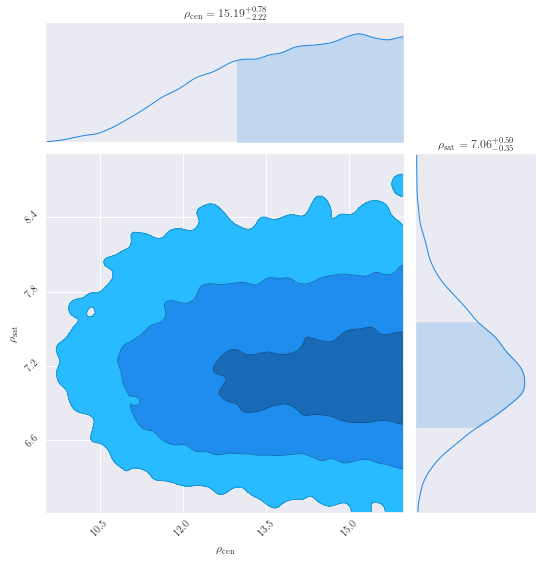

In [51]:
fig = c.plotter.plot(figsize=(8,8), parameters=param_names)#, truth = best_fit_vals)
fig.show()

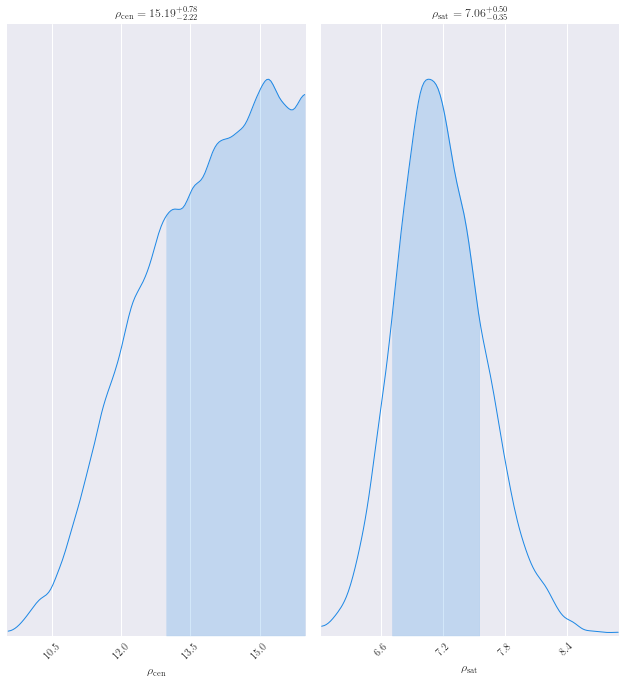

In [52]:
fig = c.plotter.plot_distributions(figsize=(10,10) )
fig.show()

In [53]:
summary  = c.analysis.get_summary()
MAP = np.array([summary[p][1] for p in param_names])
print MAP

[ 15.19325574   7.0552473 ]


In [54]:
print np.exp(MAP)

[  3.96594904e+06   1.15892404e+03]


In [55]:
print param_names

['$\\rho_{\\mathrm{cen}}$', '$\\rho_{\\mathrm{sat}}$']


In [56]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048

halo_catalog = Table.read('/u/ki/swmclau2/des/AB_tests/abmatched_halos.hdf5', format = 'hdf5')

In [57]:
shuffle_type = 'sh_shuffled'
mag_type = 'vpeak'
mag_key = 'halo_%s_mag'%(mag_type)
upid_key = 'halo_upid'

#mag_key = 'halo%s_%s_mag'%(shuffle_type, mag_type)
#upid_key = 'halo%s_upid'%shuffle_type

In [58]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)
#cat.h = 1.0

In [59]:
mag_cut = -21
min_ptcl = 200

halo_catalog = halo_catalog[halo_catalog['halo_mvir'] > min_ptcl*cat.pmass] #mass cut
galaxy_catalog = halo_catalog[ halo_catalog[mag_key] < mag_cut ] # mag cut

In [60]:
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.1):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [61]:
mass_bins = compute_mass_bins(halo_catalog['halo_mvir'], 0.2)
mass_bin_centers = (mass_bins[1:]+mass_bins[:-1])/2.0
#mass_bin_centers = 10**((np.log10(mass_bins[1:])+np.log10(mass_bins[:-1]))/2.0)

In [62]:
cen_mask = galaxy_catalog['halo_upid']==-1
mass_key = 'halo_mvir_host_halo'#
#mass_key = 'halo_%s_host_mvir'%shuffle_type
cen_hod_sham, _ = hod_from_mock(galaxy_catalog[cen_mask][mass_key],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

sat_hod_sham, _ = hod_from_mock(galaxy_catalog[~cen_mask][mass_key],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

In [63]:
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/cen_hod.npy', cen_hod_sham)
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sat_hod.npy', sat_hod_sham)
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/mbc.npy', mass_bin_centers)

In [64]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z_sham_free_split_no_rsd/'

In [65]:
#rp_bins = np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rp_bins.npy')
#rp_bins = np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rpoints.npy')
rp_bins = np.loadtxt(training_dir+'a_1.00000/global_file.npy')

#rp_bins = np.logspace(-1.1, 1.6, 16)
#rpoints =  np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rpoints.npy')
rpoints = (rp_bins[1:]+rp_bins[:-1])/2.0

#wp_sham = np.log10(np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_%s%s_wp.npy'%(mag_type, shuffle_type)))

In [66]:
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rp_bins.npy', rp_bins)

In [67]:
cat.load_model(1.0, HOD='fscabRedMagic')
#cat.load_model(1.0, HOD=(FSAssembiasTabulatedCens, FSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
#cat.load_model(1.0, HOD=(HSAssembiasTabulatedCens, HSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
#                                                               'cen_hod_vals':cen_hod_sham,
#                                                               'sat_hod_vals':sat_hod_sham})

In [68]:
cat.model.param_dict

{'alpha': 1.02,
 'f_c': 0.19,
 'logM0': 12.2,
 'logM1': 13.7,
 'logMmin': 12.1,
 'mean_occupation_centrals_assembias_param1': 0.5,
 'mean_occupation_centrals_assembias_slope1': 1.0,
 'mean_occupation_centrals_assembias_split1': 0.5,
 'mean_occupation_satellites_assembias_param1': 0.5,
 'mean_occupation_satellites_assembias_slope1': 1.0,
 'mean_occupation_satellites_assembias_split1': 0.5,
 'sigma_logM': 0.46}

In [69]:
#summary  = c.analysis.get_summary()
MAP = np.array([summary[p][1] for p in param_names])
#MAP = np.zeros((len(param_names),))
#MAP = chain[np.random.randint(chain.shape[0]), :]
print MAP

[ 15.19325574   7.0552473 ]


In [70]:
param_names

['$\\rho_{\\mathrm{cen}}$', '$\\rho_{\\mathrm{sat}}$']

In [71]:
#names = ['mean_occupation_satellites_assembias_split1','mean_occupation_satellites_assembias_param1',
#          'mean_occupation_centrals_assembias_split1', 'mean_occupation_centrals_assembias_param1']
names = ['logMmin','logM0','sigma_logM', 'logM1', 'alpha']
#names = ['mean_occupation_satellites_assembias_param1', 'mean_occupation_centrals_assembias_param1']

In [72]:
params = dict(zip(names, MAP))
params['f_c'] = 1.0
cat.populated_once = False
cat.populate(params)

In [73]:
cat.model.param_dict

{'alpha': 1.02,
 'f_c': 1.0,
 'logM0': 7.0552472985375774,
 'logM1': 13.7,
 'logMmin': 15.193255739073294,
 'mean_occupation_centrals_assembias_param1': 0.5,
 'mean_occupation_centrals_assembias_slope1': 1.0,
 'mean_occupation_centrals_assembias_split1': 0.5,
 'mean_occupation_satellites_assembias_param1': 0.5,
 'mean_occupation_satellites_assembias_slope1': 1.0,
 'mean_occupation_satellites_assembias_split1': 0.5,
 'sigma_logM': 0.46}

In [74]:
cen_mask = cat.model.mock.galaxy_table['gal_type']=='centrals'
cen_hod_mock, _ = hod_from_mock(cat.model.mock.galaxy_table[cen_mask]['halo_mvir'],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

sat_hod_mock, _ = hod_from_mock(cat.model.mock.galaxy_table[~cen_mask]['halo_mvir'],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

In [75]:
wp_hod = cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False, RSD=False)
print wp_hod
#wp_hod = cat.calc_xi(rp_bins, do_jackknife=False)

[  8.61174437e+05   6.59390693e+05   7.39076202e+05   4.84833542e+05
   3.72776661e+05   2.60941340e+05   1.83834252e+05   1.14150666e+05
   5.74686408e+04   1.45502391e+04   2.02530741e+03   2.97745459e+03
   2.94860222e+03   5.24225154e+01   2.85288586e+01   1.58688315e+01
  -2.83216728e+01  -1.40038719e+01]


In [76]:
from halotools.mock_observables import return_xyz_formatted_array

In [77]:
sham_pos = np.c_[galaxy_catalog['halo_x'],\
                 galaxy_catalog['halo_y'],\
                 galaxy_catalog['halo_z']]

wp_sham = wp(sham_pos*cat.h, rp_bins, 40.0*cat.h, period=cat.Lbox*cat.h, num_threads=1)
print wp_sham
#wp_sham = tpcf(sham_pos*h, rp_bins, period=400.0*h, num_threads=1)

#wp_sham = np.log10(wp(sham_pos, rp_bins, 40.0, period=400.0, num_threads=1))

[ 584.13088582  446.77230202  352.39713097  233.66110444  170.22857317
  116.8310956    86.1341947    63.34798862   47.95916411   36.86749563
   28.27748673   20.94600314   15.09222186   10.6114766     6.99502884
    4.19488178    2.07652477    0.73773839]


In [78]:
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_%s_%s_wp.npy'%(mag_type, shuffle_type), wp_sham)
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_vpeak_shuffled_nd.npy',np.array([cat.calc_analytic_nd()]) )

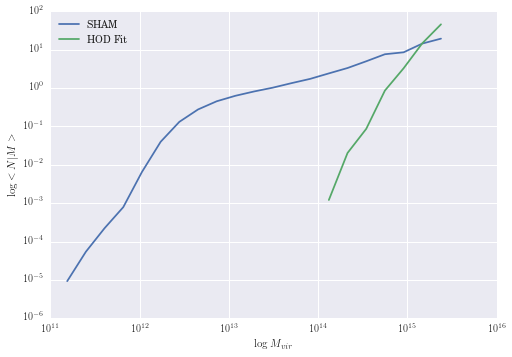

In [79]:
plt.plot(mass_bin_centers, cen_hod_sham+sat_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, cen_hod_mock+sat_hod_mock, label = 'HOD Fit')
plt.legend(loc='best')
plt.xlabel(r"$\log{M_{vir}}$")
plt.ylabel(r"$\log{<N|M>}$")
plt.loglog()
plt.show();

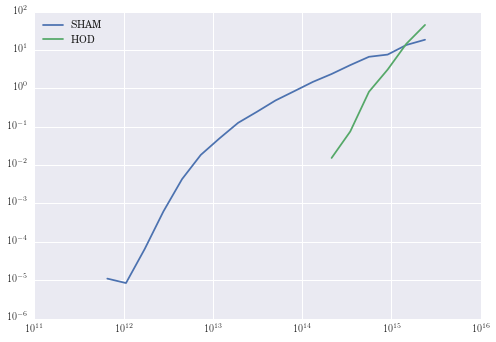

In [80]:
plt.plot(mass_bin_centers, sat_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, sat_hod_mock, label = 'HOD')
plt.legend(loc='best')

plt.vlines(PMASS*min_ptcl,0, 100)
plt.loglog()
plt.show();

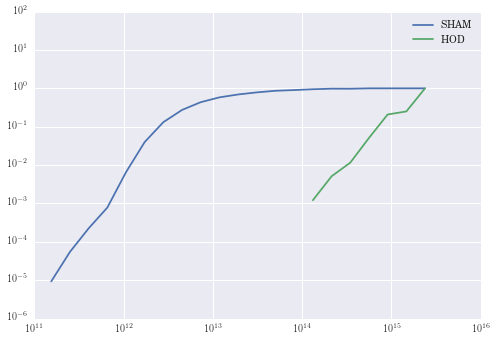

In [81]:
plt.plot(mass_bin_centers, cen_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, cen_hod_mock, label = 'HOD')
plt.legend(loc='best')

plt.vlines(PMASS*min_ptcl,0, 100)
plt.loglog()
plt.show();

In [82]:
sham_nd = len(galaxy_catalog)/(cat.Lbox*0.7)**3
hod_nd = cat.calc_analytic_nd()

In [83]:
print sham_nd/hod_nd

190.641246128


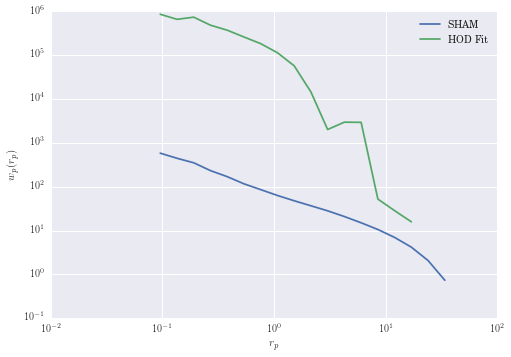

In [84]:
plt.plot(rpoints, wp_sham, label = 'SHAM')
plt.plot(rpoints, wp_hod, label = 'HOD Fit')
plt.loglog()
#plt.xscale('log')
#plt.ylim([-0.2, 3.5])
plt.legend(loc='best')
plt.xlabel(r"$r_p$")
plt.ylabel(r"$w_p(r_p)$")
plt.show()

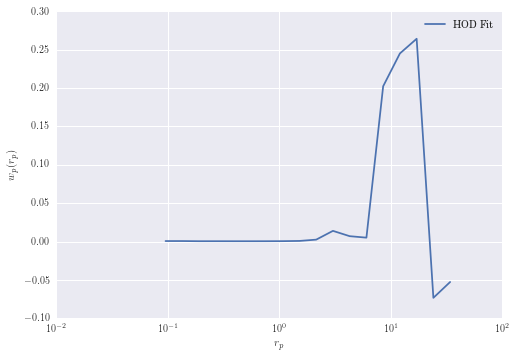

In [85]:
#plt.plot(rpoints, wp_sham, label = 'SHAM')
plt.plot(rpoints, wp_sham/wp_hod, label = 'HOD Fit')
plt.xscale('log')
#plt.xscale('log')
#plt.ylim([-0.2, 3.5])
plt.legend(loc='best')
plt.xlabel(r"$r_p$")
plt.ylabel(r"$w_p(r_p)$")
plt.show()

In [86]:
wp_hod

array([  8.61174437e+05,   6.59390693e+05,   7.39076202e+05,
         4.84833542e+05,   3.72776661e+05,   2.60941340e+05,
         1.83834252e+05,   1.14150666e+05,   5.74686408e+04,
         1.45502391e+04,   2.02530741e+03,   2.97745459e+03,
         2.94860222e+03,   5.24225154e+01,   2.85288586e+01,
         1.58688315e+01,  -2.83216728e+01,  -1.40038719e+01])

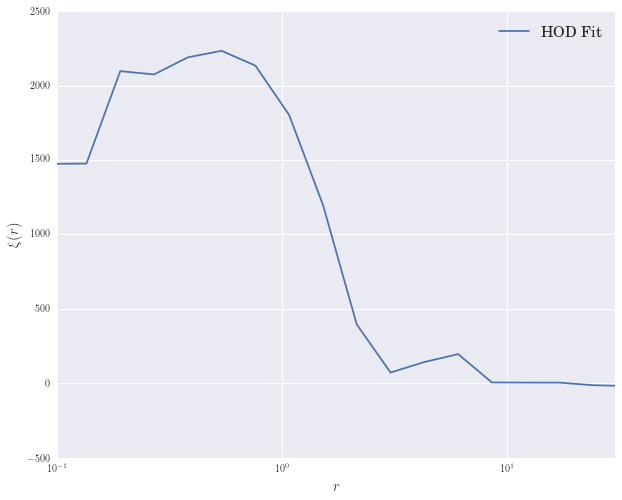

In [87]:
plt.figure(figsize=(10,8))

#plt.plot(rpoints, wp_sham/wp_sham, label = 'SHAM')
plt.plot(rpoints, wp_hod/wp_sham, label = 'HOD Fit')
plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 30e0]);
#plt.ylim([1,15000])
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)$',fontsize = 15)
plt.show()

In [88]:
print wp_sham/wp_hod

[ 0.0006783   0.00067755  0.00047681  0.00048194  0.00045665  0.00044773
  0.00046854  0.00055495  0.00083453  0.00253381  0.01396207  0.00703487
  0.00511843  0.20242212  0.24519133  0.26434724 -0.07331928 -0.05268103]


In [89]:
print wp_sham
print wp_hod

[ 584.13088582  446.77230202  352.39713097  233.66110444  170.22857317
  116.8310956    86.1341947    63.34798862   47.95916411   36.86749563
   28.27748673   20.94600314   15.09222186   10.6114766     6.99502884
    4.19488178    2.07652477    0.73773839]
[  8.61174437e+05   6.59390693e+05   7.39076202e+05   4.84833542e+05
   3.72776661e+05   2.60941340e+05   1.83834252e+05   1.14150666e+05
   5.74686408e+04   1.45502391e+04   2.02530741e+03   2.97745459e+03
   2.94860222e+03   5.24225154e+01   2.85288586e+01   1.58688315e+01
  -2.83216728e+01  -1.40038719e+01]


In [90]:
from pearce.emulator import OriginalRecipe, ExtraCrispy

In [91]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z_sham_emulator_no_rsd/'

em_method = 'gp'
split_method = 'random'

load_fixed_params = {'z':0.0}

emu = ExtraCrispy(training_dir,10, 2, split_method, method=em_method, fixed_params=load_fixed_params)

In [92]:
for n in names:
    print n, emu.get_param_bounds(n)

logMmin (12.5, 13.5)
logM0 (10, 13)
sigma_logM (0.2, 1.0)
logM1 (13.0, 16.0)
alpha (0.75, 1.25)
